# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


In [3]:
columb.head()

,index,area,home.value,income,crime,open.space,district,x,y
0,0,0.309441,80.467003,19.531,15.725980,2.850747,0,8.827218,14.369076
1,1,0.259329,44.567001,21.232,18.801754,5.296720,1,8.332658,14.031624
2,2,0.192468,26.350000,15.956,30.626781,4.534649,2,9.012265,13.819719
3,3,0.083841,33.200001,4.477,32.387760,0.394427,3,8.460801,13.716962
4,4,0.488888,23.225000,11.252,50.731510,0.405664,4,9.007982,13.296366


In [4]:
columb["home_value"] = columb["home.value"]

## Model Definition

### Setup response model

In [5]:
df = columb
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [6]:
loc += tb.slin("scale(area)*scale(income) + home_value")
loc += tb.slin("x")

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


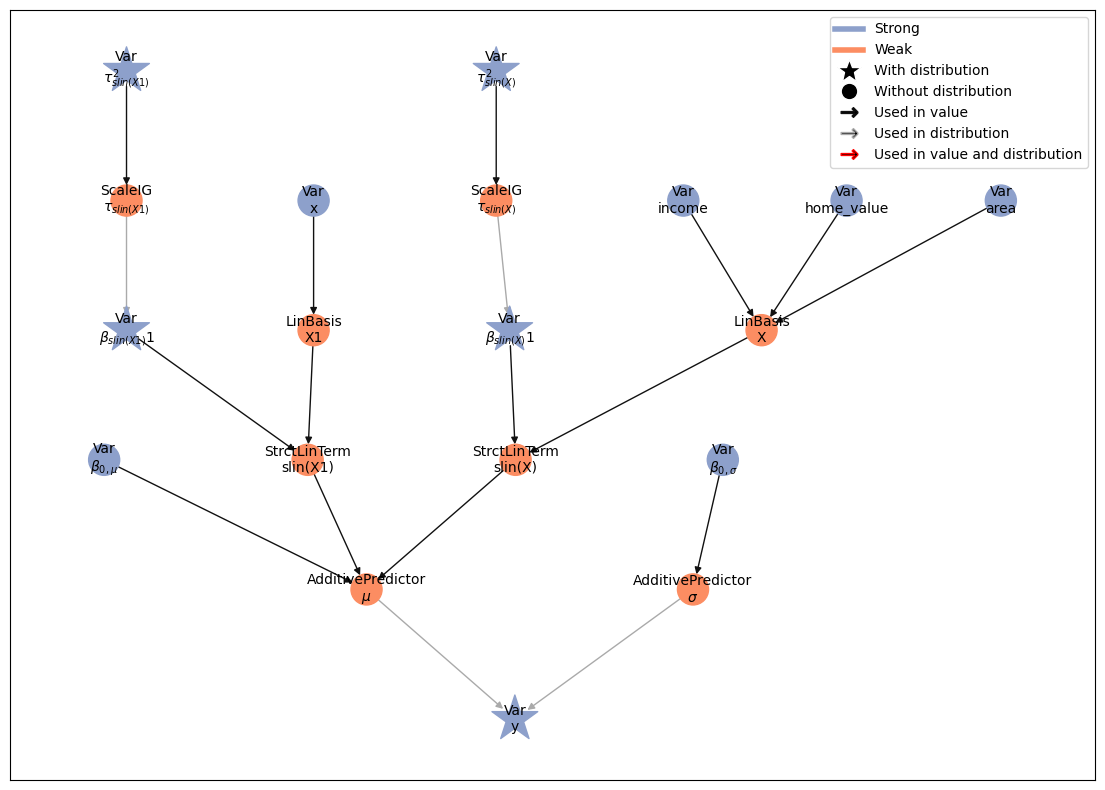

In [7]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [8]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=4000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{slin(X1)}$1', '$\\tau^2_{slin(X1)}$', '$\\beta_{slin(X)}$1', '$\\tau^2_{slin(X)}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:03<00:00,  4.22chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 939.58chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1486.81chunk/s]
liesel.goose.engine

### MCMC summary

In [9]:
summary = gs.Summary(results)
summary

Parameter summary:

                              kernel       mean        sd     q_0.05  \
parameter           index                                              
$\beta_{0,\mu}$     ()     kernel_01  50.821980  5.229132  42.221947   
$\beta_{0,\sigma}$  ()     kernel_00   2.580671  0.133684   2.357118   
$\beta_{slin(X)}$1  (0,)   kernel_04  -0.668645  1.183103  -3.196209   
                    (1,)   kernel_04  -2.038517  2.752913  -7.804309   
                    (2,)   kernel_04  -0.412353  0.120886  -0.608462   
                    (3,)   kernel_04   0.249393  1.020324  -1.055529   
$\beta_{slin(X1)}$1 (0,)   kernel_02   0.006480  0.153798  -0.193838   
$\tau^2_{slin(X)}$  ()     kernel_05   3.450877  8.345429   0.022766   
$\tau^2_{slin(X1)}$ ()     kernel_03   0.031761  0.276560   0.001622   

                               q_0.5     q_0.95  sample_size     ess_bulk  \
parameter           index                                                   
$\beta_{0,\mu}$     ()     50.845982  59.281539         4000  1136.569864   
$\beta_{0,\sigma}$  ()      2.582155   2.797849         4000   839.374558   
$\beta_{slin(X)}$1  (0,)   -0.255216   0.539112         4000  1244.843905   
                    (1,)   -0.596111   0.214935         4000   581.947626   
                    (2,)   -0.416352  -0.213538         4000  1089.571537   
                    (3,)    0.047526   2.306432         4000  2508.306963   
$\beta_{slin(X1)}$1 (0,)    0.004089   0.213948         4000  3873.293658   
$\tau^2_{slin(X)}$  ()      0.288204  16.187071         4000   522.610318   
$\tau^2_{slin(X1)}$ ()      0.007144   0.091479         4000  4004.379149   

                              ess_tail      rhat  
parameter           index                         
$\beta_{0,\mu}$     ()     1655.623211  1.001541  
$\beta_{0,\sigma}$  ()     1818.099127  1.001531  
$\beta_{slin(X)}$1  (0,)   1990.255968  1.003759  
                    (1,)   1773.376764  1.002020  
                    (2,)   1738.802054  1.001627  
                    (3,)   2158.614358  1.001355  
$\beta_{slin(X1)}$1 (0,)   3598.638250  1.000388  
$\tau^2_{slin(X)}$  ()     1794.566446  1.003634  
$\tau^2_{slin(X1)}$ ()     3656.521754  1.000067  

Error summary:

                                                   count  relative
kernel    error_code error_msg           phase                    
kernel_00 90         nan acceptance prob warmup        3  0.000188
                                         posterior     0       0.0

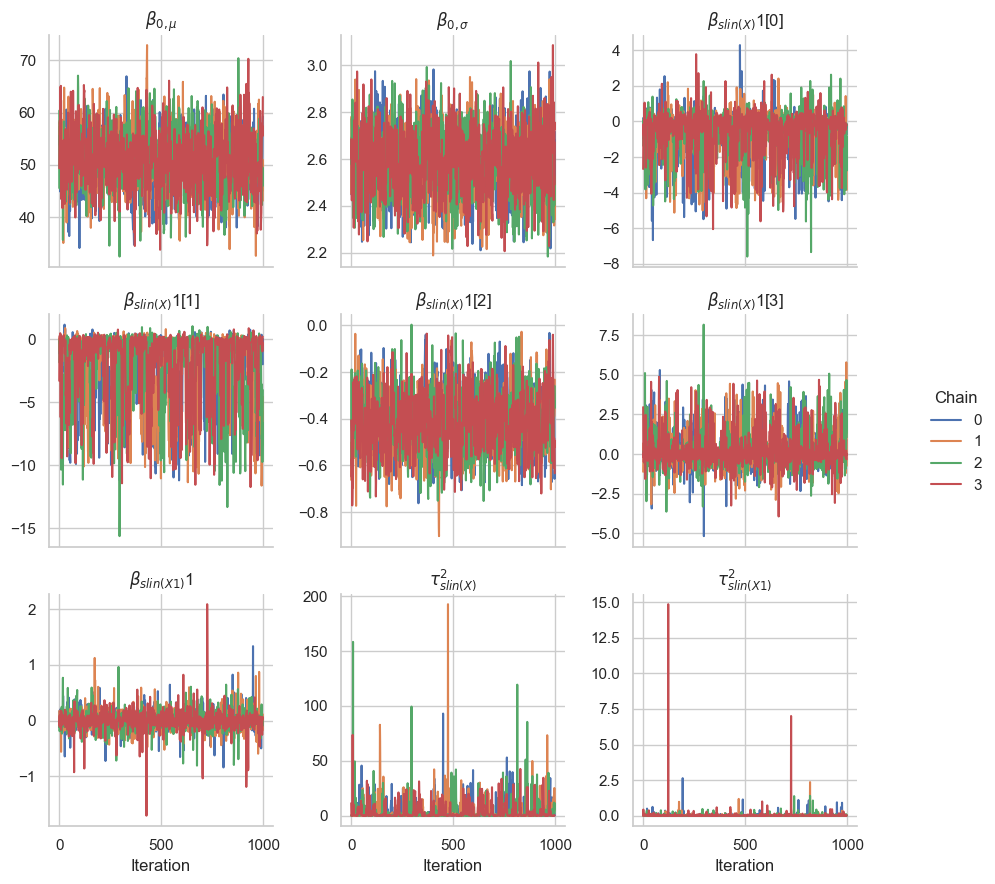

In [10]:
gs.plot_trace(results)

In [11]:
samples = results.get_posterior_samples()

In [12]:
gam.summarise_lin(model.vars["slin(X)"], samples)

,x,sample_size,mean,var,sd,ess_bulk,ess_tail,mcse_mean,mcse_sd,rhat,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high
0,scale(area),4000,-0.668645,1.399732,1.183103,1244.843905,1990.255968,0.039187,0.036423,1.003759,-3.196209,-0.255216,0.539112,-2.815860,0.719755
1,scale(income),4000,-2.038517,7.578531,2.752913,581.947626,1773.376764,0.126601,0.071088,1.002020,-7.804309,-0.596111,0.214935,-6.789279,0.456935
2,home_value,4000,-0.412353,0.014613,0.120886,1089.571537,1738.802054,0.003666,0.002107,1.001627,-0.608462,-0.416352,-0.213538,-0.609230,-0.215677
3,scale(area):scale(income),4000,0.249393,1.041060,1.020324,2508.306963,2158.614358,0.022436,0.033226,1.001355,-1.055529,0.047526,2.306432,-1.312072,1.957865


In [13]:
gam.summarise_lin(model.vars["slin(X1)"], samples)

,x,sample_size,mean,var,sd,ess_bulk,ess_tail,mcse_mean,mcse_sd,rhat,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high
0,x,4000,0.00648,0.023654,0.153798,3873.293658,3598.63825,0.002718,0.007427,1.000388,-0.193838,0.004089,0.213948,-0.198618,0.206031


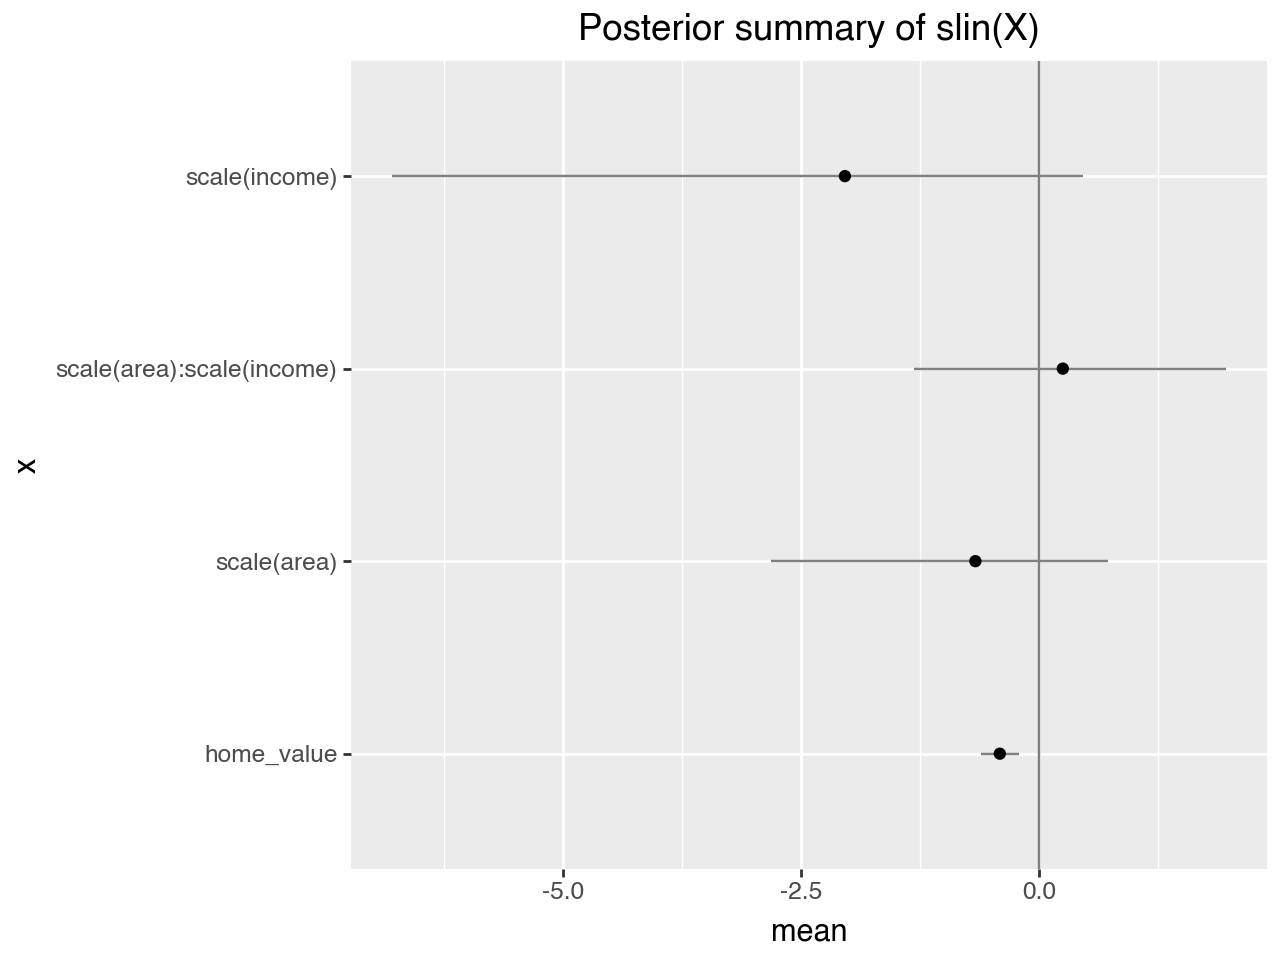

In [14]:
term = model.vars["slin(X)"]
gam.plot_forest(term, samples)

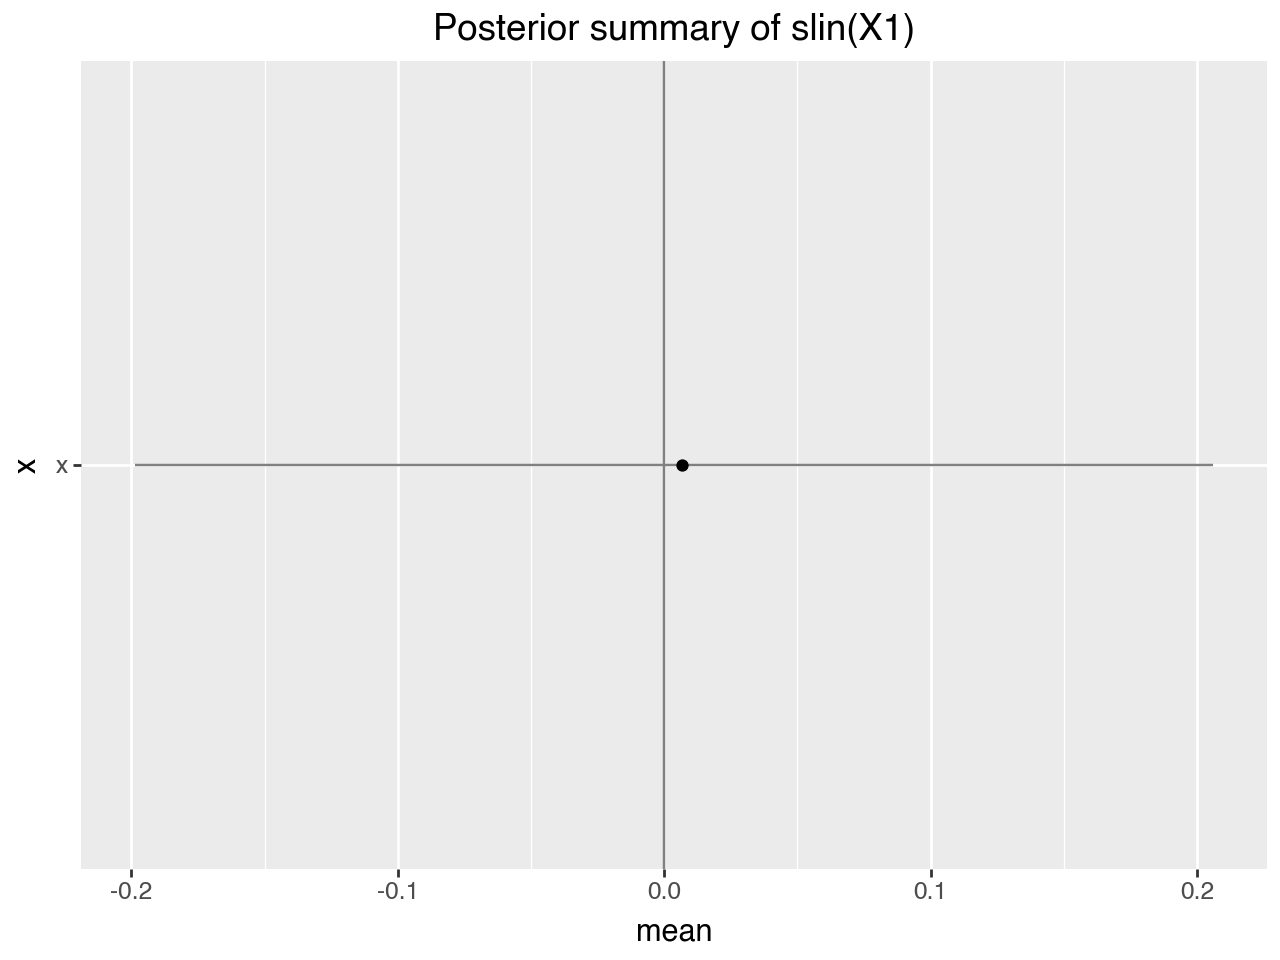

In [15]:
term = model.vars["slin(X1)"]
gam.plot_forest(term, samples)